In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy
from keras.utils.vis_utils import plot_model

C:\Users\Docente\AppData\Local\Temp\ipykernel_18852\3786466294.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Carga de datos

In [3]:
df = pd.read_csv('../data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 1995-03-01 to 2023-10-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  344 non-null    float64
 1   PD37976BM  344 non-null    float64
 2   PN02028AM  344 non-null    float64
 3   PD37972BM  344 non-null    float64
 4   PD37974BM  344 non-null    float64
 5   Class      344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


In [5]:
df.describe()

,PN02312FM,PD37976BM,PN02028AM,PD37972BM,PD37974BM,Class
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.006540,0.003332,0.002009,0.005400,0.002996,0.145349
std,0.009723,0.008992,0.006924,0.007266,0.013820,0.352966
min,-0.023125,-0.021834,-0.024268,-0.014352,-0.044618,0.000000
25%,-0.000013,-0.001842,-0.001570,0.000846,-0.004068,0.000000
50%,0.007247,0.003954,0.002133,0.006201,0.003270,0.000000
75%,0.011854,0.009464,0.006366,0.009691,0.010595,0.000000
max,0.041441,0.026307,0.026851,0.025603,0.035129,1.000000


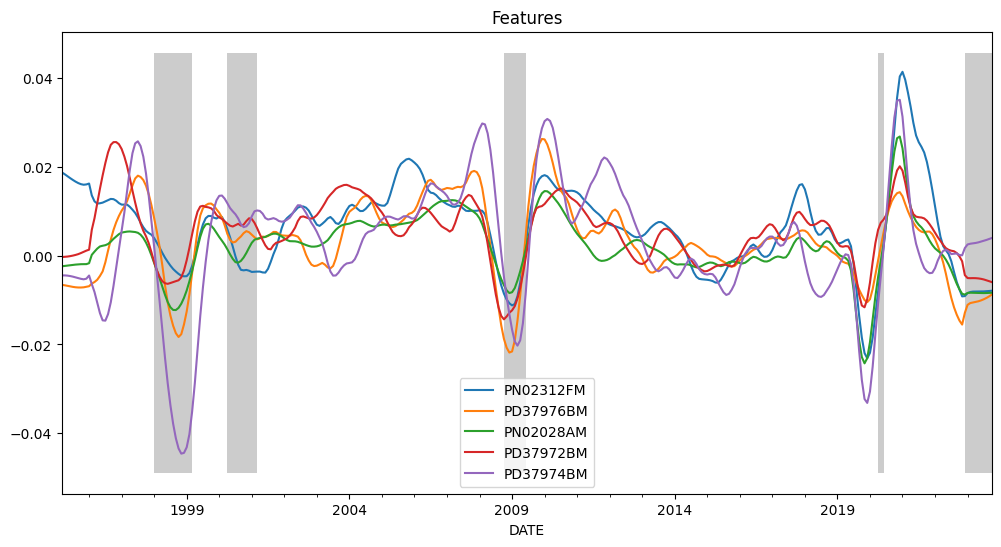

In [6]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [7]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 344
    Positive: 50 (14.53% of total)



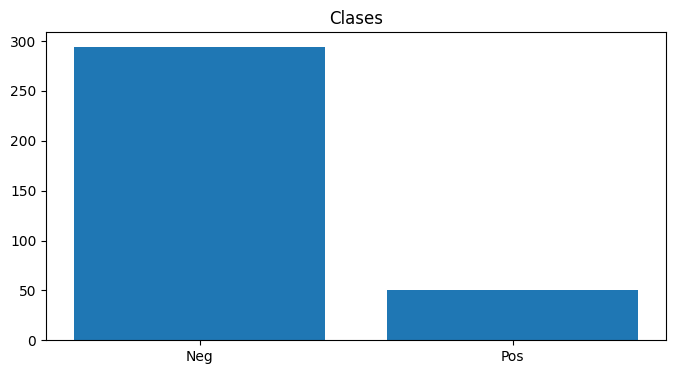

In [8]:
graficarClases(df['Class'])

In [9]:
initial_bias = np.log([pos/neg])

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.44


# Dividir Datos

In [11]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [12]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Fine Tuning

## Modelo

In [13]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_mlp(n_steps_in: int, n_features: int, nodes: int,
              layers: int, dropout : float, activation=None, output_bias = None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential()
    model.add(Flatten(input_shape=(n_steps_in, n_features)))
    for i in range(layers):
        model.add(Dense(nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    return model

In [14]:
def fine_tuning_model(base_model_path, hp, n_features):
    base_model = load_model(base_model_path)
    #print(base_model.layers[0].input_shape)
    if base_model.layers[0].input_shape[2] == n_features:
        new_model = base_model
        #print(len(new_model.layers))
        for layer in new_model.layers[:-3]:
            layer.trainable = False
    else:
        #Reconstruye el modelo
        new_model = build_mlp(
                n_steps_in = hp['steps_in'],
                n_features = n_features,
                nodes = hp['nodes'],
                layers = hp['layers'],
                dropout = hp['dropout'],
                activation = 'relu',
                output_bias = initial_bias
        )
        for i in range(1,len(base_model.layers)):
            try:
                new_model.layers[0]._batch_input_shape
                new_model.layers[i].set_weights(base_model.layers[i].get_weights())
            except:
                print(f'No se pudo transferir pesos a {new_model.layers[i].name}')

    new_model.compile(optimizer=Adam(learning_rate=1e-3),
                loss=BinaryCrossentropy(), metrics=METRICS)
    return new_model


Variables

In [15]:
n_steps_out = [1,6,12,24]
n_features = len(features)
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
n_epochs = 2000

In [16]:
output_path_model = 'modelos/'
name_prj = 'MLP_TL_PERU_'
N = 20

In [17]:
hps = [
    {'steps_in': 24, 'layers': 4, 'nodes': 160, 'dropout': 0.3},
    {'steps_in': 7, 'layers': 3, 'nodes': 160, 'dropout': 0.5},
    {'steps_in': 24, 'layers': 4, 'nodes': 144, 'dropout': 0.1},
]
base_models = [
    'modelos/MLP_USA_1_20240211_1447_2.h5',
    'modelos/MLP_USA_6_20240211_1447_2.h5',
    'modelos/MLP_USA_12_20240211_1447_9.h5',
]

In [18]:
def entrenar(name_prj, n_steps_out, base_model_path, hp):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora

    # --------------------- Entrenamiento --------------------------------------
    n_steps_in = hp['steps_in']
    x_train, y_train, _ = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test, _ = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)

    print("Entrenando...")
    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        mlp_model = fine_tuning_model(base_model_path, hp, n_features)
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='precision', 
            verbose=0,
            patience=50,
            mode='max',
            restore_best_weights=True)

        models.append(name_model)
        mlp_model.fit(x=x_train, y=y_train, validation_split = 0.5, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], 
            batch_size = batch_learning, class_weight = class_weight)

        mlp_model.save(name_model) 
        # --------------------- Evaluacion --------------------------------------
        res = mlp_model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[6]) #guarda metrica a comparar
    
    #--------- Evaluando el mejor ------------------------
    print("Evaluando mejor...")
    best_model = models[np.argmax(prcs)]
    print(f'\nMejor modelo: {best_model} con precision: {np.max(prcs)}\n')
    for i in range(N):
        if i == np.argmax(prcs):
            continue
        os.remove(models[i])

    mlp_model = load_model(best_model)
    train_predictions = mlp_model(x_train) #, batch_size=batch_learning
    test_predictions = mlp_model(x_test)

    plot_cm(y_test, test_predictions)
    plot_roc(y_train, train_predictions, y_test, test_predictions)
    plot_prc(y_train, train_predictions, y_test, test_predictions)
    plot_probs(y_train, train_predictions, 'Train')
    plot_probs(y_test, test_predictions, 'Test')

# Modelo para 1 mes a futuro

c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_1_20240211_1810_1.h5 con precision: 0.37142857909202576

Expansiones Detectadas (Verdadero Negativos):  43
Expansiones Incorrecas Detectadas (Falso Positivos):  22
Recesiones no Detectadas (False Negativos):  1
Recesiones Detectadas (Verdadero Positivos):  13
Total de Recesiones:  14


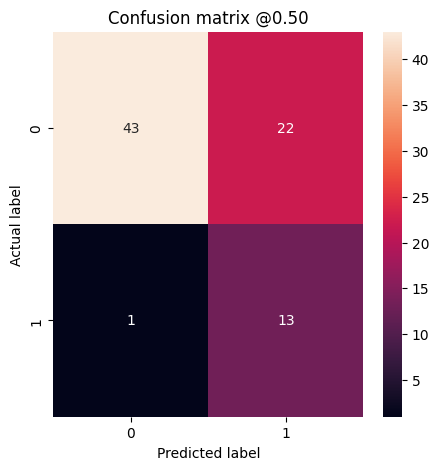

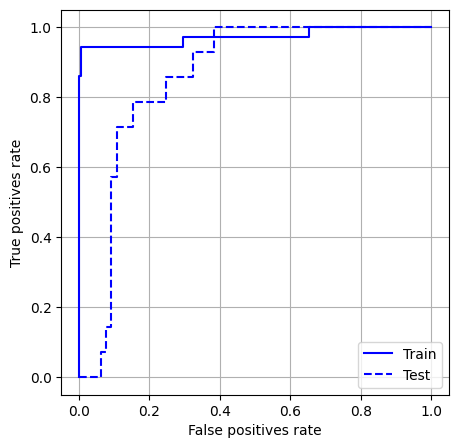

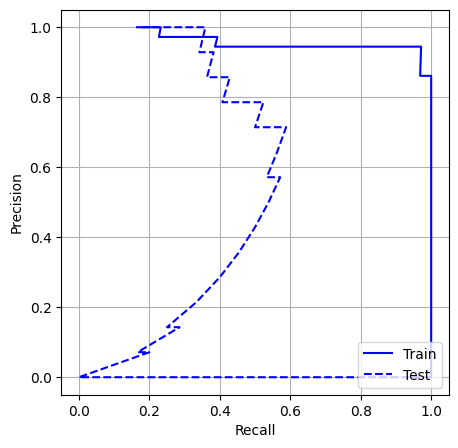

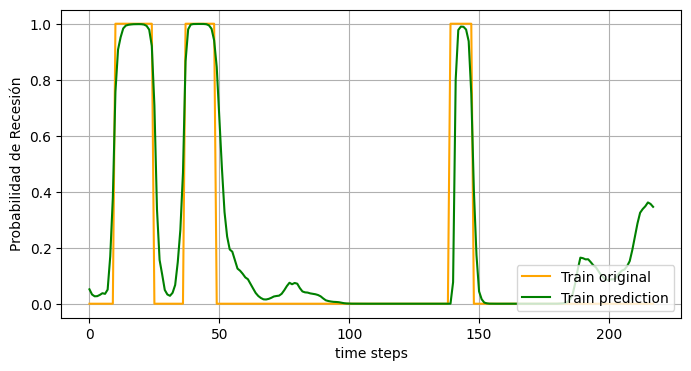

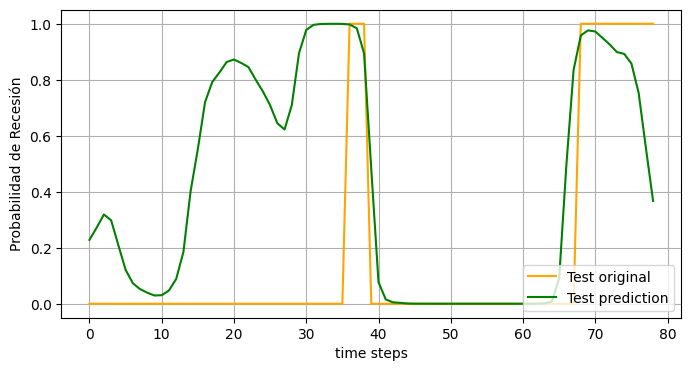

In [19]:
entrenar(name_prj, n_steps_out[0], base_models[0], hps[0])

# Modelo para 6 meses a futuro

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_6_20240211_1810_13.h5 con precision: 0.5

Expansiones Detectadas (Verdadero Negativos):  67
Expansiones Incorrecas Detectadas (Falso Positivos):  10
Recesiones no Detectadas (False Negativos):  4
Recesiones Detectadas (Verdadero Positivos):  10
Total de Recesiones:  14


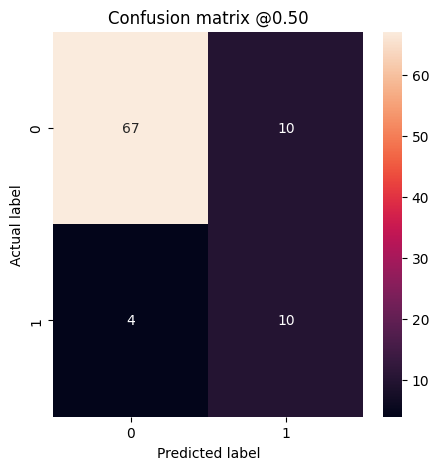

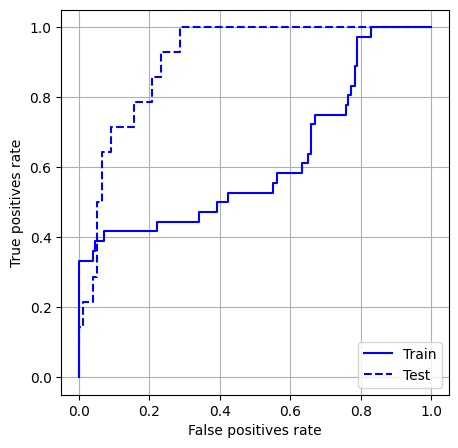

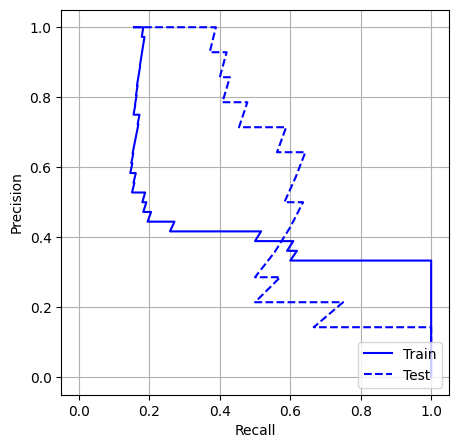

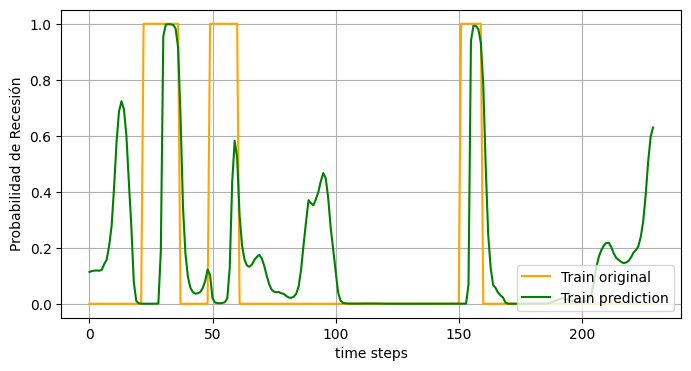

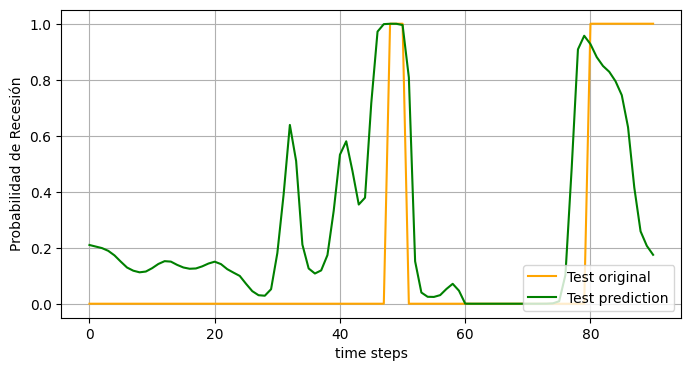

In [20]:
entrenar(name_prj, n_steps_out[1], base_models[1], hps[1])

# Modelo para 12 meses a futuro

c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_12_20240211_1810_5.h5 con precision: 0.25

Expansiones Detectadas (Verdadero Negativos):  51
Expansiones Incorrecas Detectadas (Falso Positivos):  3
Recesiones no Detectadas (False Negativos):  13
Recesiones Detectadas (Verdadero Positivos):  1
Total de Recesiones:  14


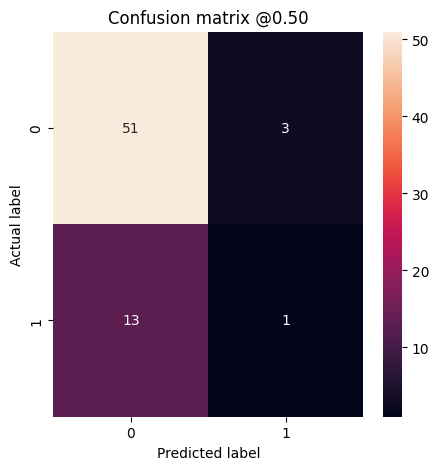

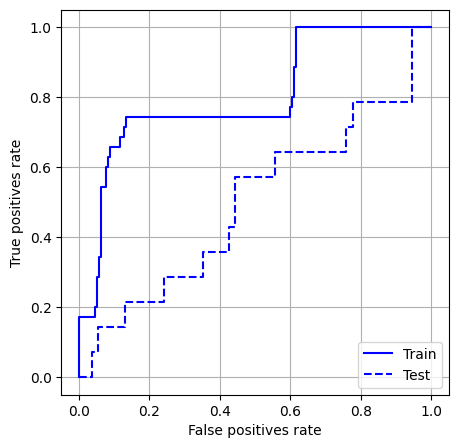

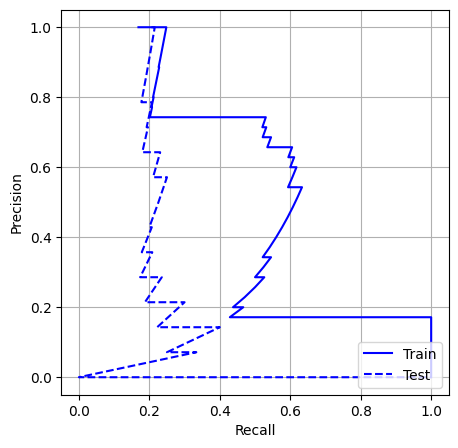

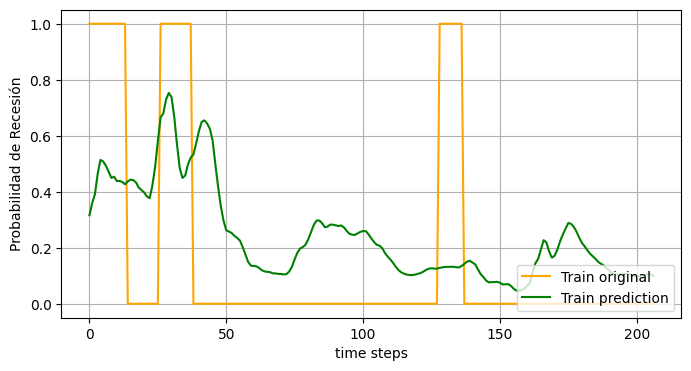

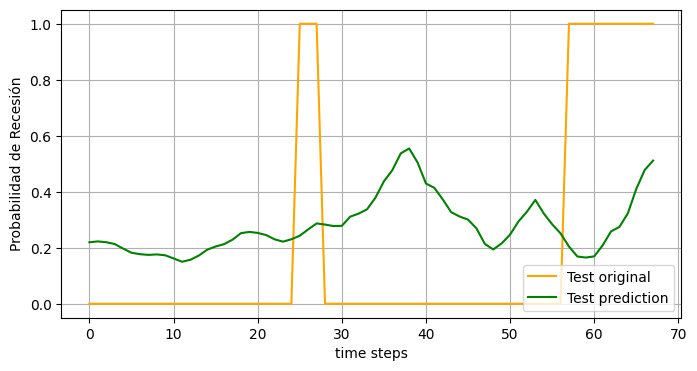

In [21]:
entrenar(name_prj, n_steps_out[2], base_models[2], hps[2])

In [22]:
from notifications import enviar_correo
subject = 'MLP_TL_PERU hyper finish'
msg = 'Termino la evaluacion'
enviar_correo(subject=subject, msg=msg)